In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
plt.rcParams['figure.figsize'] = [10, 6]

K = 10 #number of possible actions
N = 1000 #number of steps
num_simulations = 1000 #number of simulations for averaging

In [2]:
#create K-handed Bernoulli bandit
def create_bandit(K):
    theta = []
    for k in range(K):
        theta.append(np.random.beta(1,1))
    return theta

In [3]:
#try k-th action
def play(theta, k):
    return np.random.random() < theta[k]

In [4]:
def epsilon_greedy(theta, epsilon, alpha, beta):
    alpha = alpha*np.ones(K)
    beta = beta*np.ones(K)
    chosen_actions = []

    for t in range(N):
        if np.random.random() < epsilon:
            chosen_actions.append(np.random.randint(0, K))
        else:
            theta_sampled = alpha/(alpha + beta)
            chosen_actions.append(
                np.random.choice([i for i in range(K) if theta_sampled[i] == np.max(theta_sampled)]))

        reward = play(theta, chosen_actions[-1])

        alpha[chosen_actions[-1]] += reward
        beta[chosen_actions[-1]] += 1 - reward
        
    return chosen_actions

In [5]:
def annealing_epsilon_greedy(theta, m, alpha, beta):
    alpha = alpha*np.ones(K)
    beta = beta*np.ones(K)
    chosen_actions = []

    for t in range(N):
        epsilon = m/(m+t)
        
        if np.random.random() < epsilon:
            chosen_actions.append(np.random.randint(0, K))
        else:
            theta_sampled = alpha/(alpha + beta)
            chosen_actions.append(
                np.random.choice([i for i in range(K) if theta_sampled[i] == np.max(theta_sampled)]))
            
        reward = play(theta, chosen_actions[-1])
        
        alpha[chosen_actions[-1]] += reward
        beta[chosen_actions[-1]] += 1 - reward
        
    return chosen_actions

In [6]:
def thompson_sampling(theta, alpha=1, beta=1):
    alpha = alpha*np.ones(K)
    beta = beta*np.ones(K)
    chosen_actions = []
    for t in range(N):
        theta_sampled = []
        for k in range(K):
            theta_sampled.append(np.random.beta(alpha[k], beta[k]))

        chosen_actions.append(np.argmax(theta_sampled))

        reward = play(theta, chosen_actions[-1])

        alpha[chosen_actions[-1]] += reward
        beta[chosen_actions[-1]] += 1 - reward
    
    return chosen_actions

In [7]:
#per-period regret (in one simulation)
def per_period_regret(chosen_actions, theta):
    regret = []
    for i in range(N):
        regret.append(np.max(theta) - theta[chosen_actions[i]])
    # return [np.mean(regret[:i+1]) for i in range(N)]
    return regret

In [8]:
def plot_averaged_regrets(alg_actions_dict, theta):
    fig, ax = plt.subplots()
    
    for algorithm in alg_actions_dict:
        avg_regret = [np.mean(per_period_regret(alg_actions_dict[algorithm], theta)[:i+1]) for i in range(N)]
        ax.plot(range(N), avg_regret, label=algorithm)
    
    ax.legend()
    ax.set_title('average regret per t time periods')
    ax.set_xlabel('time period t')
    ax.set_ylabel(None)

    plt.show()

In [9]:
def print_statistics_table(alg_actions_dict):
    data = [
        ['Actions:'] + list(range(K)),
        ['Probability:'] + list(np.around(theta, decimals=3))
    ]
    for algorithm in alg_actions_dict:
        data.append([algorithm] + [alg_actions_dict[algorithm].count(i) for i in range(K)])
        
    print(tabulate(data, tablefmt="fancy_grid", numalign="right"))

In [10]:
%%time
theta = create_bandit(K)

EG001_actions = epsilon_greedy(theta, epsilon=0.01, alpha=1, beta=1)
EG01_actions = epsilon_greedy(theta, epsilon=0.1, alpha=1, beta=1)
AEG_actions = annealing_epsilon_greedy(theta, m=9, alpha=1, beta=1)
TS_actions = thompson_sampling(theta, alpha=1, beta=1)

CPU times: total: 109 ms
Wall time: 122 ms


Count of chosen actions for every algorithm:
╒═══════════════════╤═══════╤══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ Actions:          │     0 │    1 │     2 │     3 │     4 │     5 │     6 │     7 │     8 │     9 │
├───────────────────┼───────┼──────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ Probability:      │ 0.307 │ 0.02 │ 0.083 │ 0.642 │ 0.343 │ 0.594 │ 0.634 │ 0.621 │ 0.592 │ 0.788 │
├───────────────────┼───────┼──────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ 0.01-greedy       │     3 │    1 │     2 │     0 │     0 │     2 │   967 │    22 │     1 │     2 │
├───────────────────┼───────┼──────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ 0.1-greedy        │    12 │   10 │    13 │   518 │    13 │   179 │    14 │   214 │    14 │    13 │
├───────────────────┼───────┼──────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ 9/(9+t)-greedy    │     8 │    5 │     8 │  

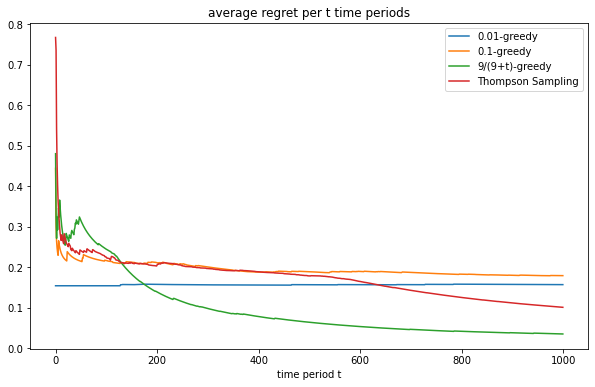

In [11]:
alg_actions_dict = {'0.01-greedy' : EG001_actions,
                    '0.1-greedy' : EG01_actions,
                    '9/(9+t)-greedy' : AEG_actions,
                    'Thompson Sampling' : TS_actions}

print('Count of chosen actions for every algorithm:')
print_statistics_table(alg_actions_dict)
plot_averaged_regrets(alg_actions_dict, theta)

In [12]:
#plot per-period regret (average over many simulations)
def plot_mean_per_period_regret(alg_regret_dict):
    fig, ax = plt.subplots()
    
    for algorithm in alg_regret_dict:
        ax.plot(range(N), np.mean(alg_regret_dict[algorithm], axis=0), label=algorithm)

    ax.legend()
    ax.set_title(f'mean per-period regret over {num_simulations} simulations')
    ax.set_xlabel('time period')
    ax.set_ylabel(None)

    plt.show()

In [13]:
#simulate a bunch of algorithms
def simulate(algorithms, params, num_simulations=num_simulations):
    actions = []
    avg_per_period_regret = []
    names = []
    for j in range(len(algorithms)):
        actions.append([])
        avg_per_period_regret.append([])
        
    for i in range(num_simulations):
        theta = create_bandit(K)
        
        for j in range(len(algorithms)):
            if algorithms[j] == 'epsilon_greedy':
                actions[j].append(epsilon_greedy(theta, epsilon=params[j][0], alpha=params[j][1], beta=params[j][2]))
                names.append(f'{params[j][0]}-greedy with alpha={params[j][1]} and beta={params[j][2]}')
            elif algorithms[j] == 'Annealing_Epsilon_Greedy':
                actions[j].append(annealing_epsilon_greedy(theta, m=params[j][0], alpha=params[j][1], beta=params[j][2]))
                names.append(f'{params[j][0]}/({params[j][0]}+t)-greedy with alpha={params[j][1]} and beta={params[j][2]}')
            elif algorithms[j] == 'thompson_sampling':
                actions[j].append(thompson_sampling(theta, alpha=params[j][0], beta=params[j][1]))
                names.append(f'Thompson Sampling with alpha={params[j][0]} and beta={params[j][1]}')
            avg_per_period_regret[j].append(per_period_regret(actions[j][i], theta)) 
    
    alg_regret_dict = {names[j] : avg_per_period_regret[j] for j in range(len(algorithms))}
    return alg_regret_dict

*simulate()* inputs have following form:

*algorithms = [alg_1, alg_2, alg_3, ..., alg_n]*, where *alg_i* is *'epsilon_greedy'*, *'Annealing_Epsilon_Greedy'* or *'thompson_sampling'*.

*params = [[x_1, a_1, b_1], [x_1, a_2, b_2], [x_3, a_3, b_3], ..., [x_n, a_n, b_n]]*, where *a_i* is alpha of prior distribution, *b_i* is beta of prior distribution, and *x_i* is hyperparameter of corresponding algorithm (*epsilon* for *'epsilon_greedy'*, *m* for *'Annealing_Epsilon_Greedy'* or nothing for *'thompson_sampling'*).

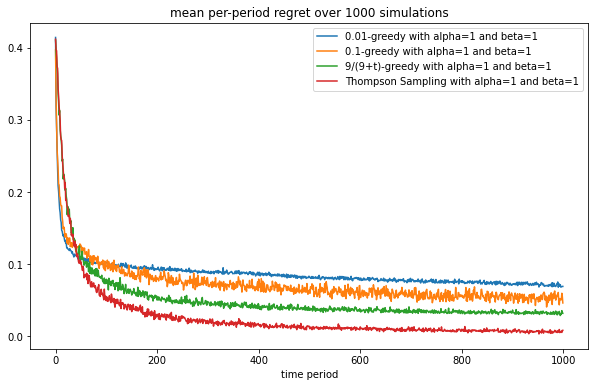

CPU times: total: 2min 16s
Wall time: 2min 16s


In [14]:
%%time
alg_regret_dict = simulate(['epsilon_greedy', 'epsilon_greedy', 'Annealing_Epsilon_Greedy', 'thompson_sampling'],
                           [[0.01,1,1], [0.1,1,1], [9,1,1], [1,1]],
                           num_simulations=1000)
plot_mean_per_period_regret(alg_regret_dict)

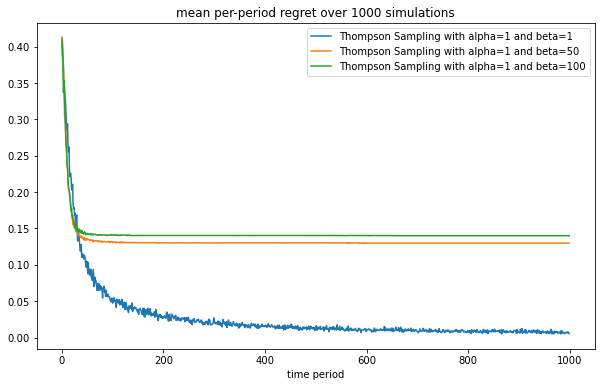

CPU times: total: 50.1 s
Wall time: 50.1 s


In [15]:
%%time
alg_regret_dict = simulate(['thompson_sampling', 'thompson_sampling', 'thompson_sampling'],
                           [[1,1], [1,50], [1,100]],
                           num_simulations=1000)
plot_mean_per_period_regret(alg_regret_dict)